# Intro to Pyro Models

In [1]:
import torch
import pyro

pyro.set_rng_seed(101)

## Primitive Stochastic Functions

These are an important class of stochastic functions for which we can explicitly compute the probability of the outputs given the inputs. For example, to draw `x` from $N(0, 1)$ we do:

In [5]:
loc = 0
scale = 1
normal = torch.distributions.Normal(loc, scale)
x = normal.rsample()
print(x)
print("log prob: ", normal.log_prob(x).numpy())

tensor(0.7377)
log prob:  -1.1910676


Here, `torch.distributions.Normal` is an instance of the `Distribution` class that takes parameters and provides sample and score methods. Pyro’s distribution library `pyro.distributions` is a thin wrapper around `torch.distributions` because we want to make use of PyTorch’s fast tensor math and autograd capabilities during inference.

## A Simple Model

In [32]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

weather()

('sunny', 58.6500129699707)

This `weather` function is entirely independent of Pyro, it uses PyTorch. We need to replace `torch.distributions` to `pyro.distributions` to take advantage of Pyro's fast tensor math. We also need to change `rsample()` to `sample()`.
Using `pyro.sample` is as simple as calling a primitive stochastic function with one main difference: 

In [34]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-1.6629)


Just like `torch.rsample()`, we are returned a random sample, however now it has been _named_. Pyro's backend uses these names to uniquely identify variables and update them at runtime depending on how the enclosing stochastic function is being used. Now we can re-write the function:

In [41]:
def weather () :
    cloudy = pyro.sample("cloudy", pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample("temp", pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

weather()

('sunny', 81.04468536376953)

## More

In [42]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

ice_cream_sales()

tensor(63.9332)

In [75]:
# count number of failures until a success: example of nondeterministically stopping recursion
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)

print(geometric(0.1))

5


## Introduction to Inference with Pyro

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

from torch.distributions import constraints # for constraining parameters

pyro.set_rng_seed(101)

We are trying to compensate for for the variability in in a scale by integrating the noisy measurement information with a guess based on some prior knowledge of the object being weighed.

$$ weight | guess \sim N(guess, 1) $$
$$ measurement | guess, weight \sim N(weight, 0.75) $$

This corresponds to the following stochastic function:

In [80]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [82]:
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

In some cases it might be more convenient to pass observations directly to individual `pyro.sample` statements instead of using `pyro.condition`. The optional `obs` keyword argument is reserved by `pyro.sample` for that purpose.

In [90]:
def scale_obs(guess):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we condition on measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 0.75), obs=9.5)

Now that we have conditioned on an observation of `measurement`, we can use Pyro's approximate inference algorithms to estimate a distribution over `weight` given `guess` and `measurement==data`.

Inference algorithms in Pyro, such as pyro.infer.SVI, allow us to use arbitrary stochastic functions, which we will call guide functions or guides, as approximate posterior distributions. Guide functions must satisfy these two criteria to be valid approximations for a particular model: 1. all unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. 2. the guide has the same input signature as the model (i.e., takes the same arguments)

Guide functions can serve as programmable, data-dependent proposal distributions for importance sampling, rejection sampling, sequential Monte Carlo, MCMC, and independent Metropolis-Hastings, and as variational distributions or inference networks for stochastic variational inference. Currently, importance sampling, MCMC, and stochastic variational inference are implemented in Pyro, and we plan to add other algorithms in the future.

In [83]:
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

### Parametrized Stochastic Functions and Variational Inference


Usually the posterior is intractable, what we can do instead is use the top-level function `pyro.param` to specify a family of guides indexed by named parameters, and search for the member of that family that is the best approximation according to some loss function. This approach to approximate posterior inference is called variational inference.

In [84]:
# we parametize a and b instead of specifying them by hand:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

Note here that we have to use `torch.abs()` to specify the standard deviation of the Normal. `torch.distributions` contains a `constraints()` module for this:

In [96]:
def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive) # specify the constraint here
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

a =  9.134031295776367
b =  0.6222702264785767


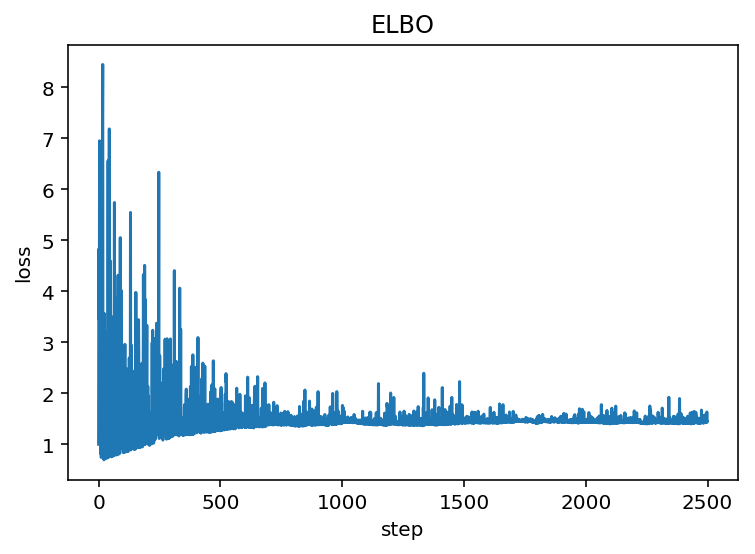

In [101]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale, 
                     guide=scale_parametrized_guide_constrained, # guide
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}), # optimizer
                     loss=pyro.infer.Trace_ELBO()) # loss function 


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

_ = plt.plot(losses)
_ = plt.title("ELBO")
_ = plt.xlabel("step")
_ = plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

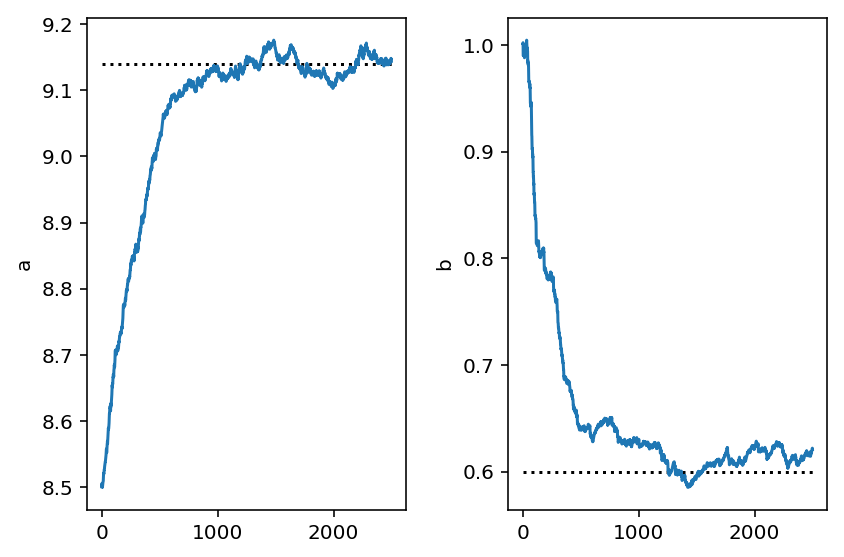

In [95]:
_ = plt.subplot(1,2,1)
_ = plt.plot([0,num_steps],[9.14,9.14], 'k:')
_ = plt.plot(a)
_ = plt.ylabel('a')

_ = plt.subplot(1,2,2)
_ = plt.ylabel('b')
_ = plt.plot([0,num_steps],[0.6,0.6], 'k:')
_ = plt.plot(b)
_ = plt.tight_layout()